In [1]:
import sys
import os
sys.path.append('..')
import edlib
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy
import bisect

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

# Transforming reads into monoreads

In [2]:
sys.path.append('../centroFlye_repo/scripts')

import networkx as nx
import numpy as np
import subprocess

from debruijn_graph import DeBruijnGraph, get_frequent_kmers
from sd_parser import SD_Report, get_stats
from mono_error_correction import error_correction
from utils.bio import read_bio_seqs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sd_report_fn = '../data/centroFlyeMono_results_cen6/string_decomposer_report/decomposition.tsv'
monomers_fn = '../data/D6Z1/D6Z1_monomers.fasta'

sd_report = SD_Report(SD_report_fn=sd_report_fn, monomers_fn=monomers_fn)

In [4]:
get_stats(sd_report.monostrings, verbose=True, return_stats=False)

Number of translations: 6558
Min length = 17
Mean length = 238.32464165904238
Max length = 3195
Total length = 1562933
#(%) Gap symbols = 34303 (0.021947837815184657)
#Gap runs = 7375


In [5]:
monoreads = error_correction(sd_report.monostrings, verbose=True, inplace=False)

Stats for uncorrected reads
Number of translations: 6558
Min length = 17
Mean length = 238.32464165904238
Max length = 3195
Total length = 1562933
#(%) Gap symbols = 34303 (0.021947837815184657)
#Gap runs = 7375

Stats for filtered reads
Number of translations: 6537
Min length = 17
Mean length = 237.9418693590332
Max length = 3195
Total length = 1555426
#(%) Gap symbols = 33437 (0.02149700467910399)
#Gap runs = 7297

Stats for trimmed+filtered reads
Number of translations: 6537
Min length = 0
Mean length = 235.28805262352762
Max length = 3195
Total length = 1538078
#(%) Gap symbols = 20807 (0.013527922511082013)
#Gap runs = 6190

Stats for cut_gaprich_reads+trimmed+filtered reads
# cut reads = 124
# total cut parts = 188
Number of translations: 6412
Min length = 0
Mean length = 228.91593886462883
Max length = 2662
Total length = 1467809
#(%) Gap symbols = 5989 (0.004080231147240547)
#Gap runs = 3193

Stats for hor_corrected+cut_gaprich_reads+trimmed+filtered reads
Number of translation

# Subsampling (S6.4)

In [6]:
assembly_decomp = '../data/centroFlyeMono_results_cen6/string_decomposition_assembly/decomposition.tsv'


In [7]:
assembly_sd_report = SD_Report(SD_report_fn=assembly_decomp, monomers_fn=monomers_fn)

In [8]:
assembly = assembly_sd_report.monostrings['scaffold_0_niter_1'].tostring()

In [9]:
import os
import random
from utils.trim_seqs import trim_seqs

In [10]:
def assembly_cov_scaffolds(assembly, scaffolds, max_ed=100, verbose=False):
    cov = [0] * (len(assembly) + 1)
    for i, scaffold in enumerate(scaffolds):
        alignment = edlib.align(scaffold, assembly, mode='HW',
                                k=max_ed,
                                task='locations')
        if verbose:
            print(i, alignment)
        loc = alignment['locations']
        if len(loc) > 1:
            continue
        loc = loc[0]
        cov[loc[0]] += 1
        cov[loc[1]] -= 1
    cov = np.cumsum(cov)
    return cov

In [11]:
def subsample(monoreads,
              assembly,
              outdir,
              nreads_freqs=[0.8, 0.7, 0.5],
              seeds=[910392],
              min_k=100,
              max_k=400,
              min_mult=3,
              read_cut_freqs=[0, 0.05, 0.1],
              verbose=True):
    # monoreads = deepcopy(monoreads)
    all_scaffolds = {}
    all_dbs = {}
    all_long_monoreads = {r_id: monoread for r_id, monoread in monoreads.items()
                          if len(monoread) >= min_k}
    print(f'#reads {len(monoreads)}. #long reads {len(all_long_monoreads)}')
    for seed in seeds:
        for nreads_freq in nreads_freqs:
            for rc_freq in read_cut_freqs:
                random.seed(seed)
                long_monoreads_ids = random.sample(all_long_monoreads.keys(),
                                                   k=int(len(all_long_monoreads)*nreads_freq))
                long_monoreads = {r_id: all_long_monoreads[r_id] for r_id in long_monoreads_ids}
                long_monoreads = deepcopy(long_monoreads)
                for read in long_monoreads.values():
                    left_ind = int(len(read)*rc_freq)
                    right_ind = int(len(read)*(1-rc_freq))
                    read.trim_read(left_ind, right_ind)
                contigs, dbs, all_frequent_kmers, all_frequent_kmers_read_pos = \
                    iterative_graph(long_monoreads, min_k=min_k, max_k=max_k,
                                    outdir=os.path.join(outdir, f'seed_{seed}_nreadsFreq_{nreads_freq}_readCutFreq_{rc_freq}'),
                                    min_mult=min_mult,
                                    verbose=False)
                db = dbs[max_k]
                mappings = db.map_reads(long_monoreads, verbose=False)
                scaffolds, edge_scaffolds = scaffolding(db, mappings)
                all_scaffolds[(seed, nreads_freq, rc_freq)] = (scaffolds, edge_scaffolds)
                all_dbs[(seed, nreads_freq, rc_freq)] = db
                cov = assembly_cov_scaffolds(assembly, scaffolds, verbose=verbose)
                plt.plot(cov)
                print('seed', seed, 'nreadsFreq', nreads_freq, 'readCutFreq', rc_freq)
                plt.title(f'{len(scaffolds)} scaffolds. Reads downsampled to {int(nreads_freq*100)}%. Trimmed by {int(rc_freq*100*2)}%')
                plt.xlabel('monomers')
                plt.ylabel('coverage')
                plt.show()
    return all_scaffolds, all_dbs

#reads 6412. #long reads 4586
0 {'editDistance': 3, 'alphabetLength': 18, 'locations': [(0, 11154)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(11128, 16337)], 'cigar': None}
seed 910392 nreadsFreq 0.8 readCutFreq 0


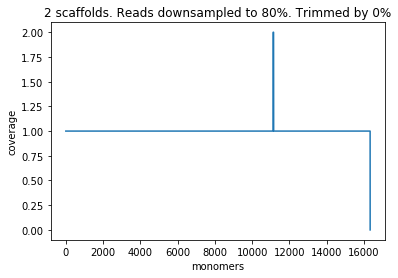

0 {'editDistance': 2, 'alphabetLength': 18, 'locations': [(43, 11088)], 'cigar': None}
1 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 16332)], 'cigar': None}
seed 910392 nreadsFreq 0.8 readCutFreq 0.05


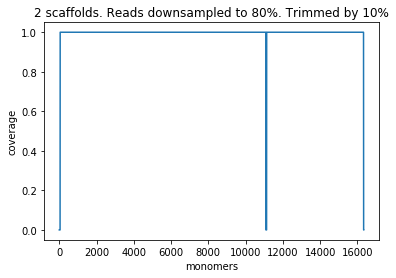

0 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1305, 7425)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(6916, 11088)], 'cigar': None}
2 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13505, 16323)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(88, 1663)], 'cigar': None}
4 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 13866)], 'cigar': None}
seed 910392 nreadsFreq 0.8 readCutFreq 0.1


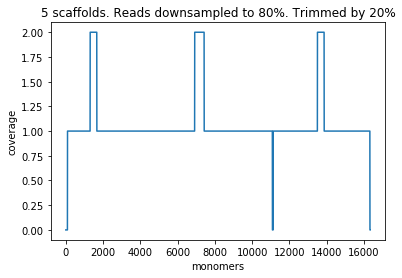

0 {'editDistance': 3, 'alphabetLength': 18, 'locations': [(0, 11154)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(11128, 16337)], 'cigar': None}
seed 910392 nreadsFreq 0.7 readCutFreq 0


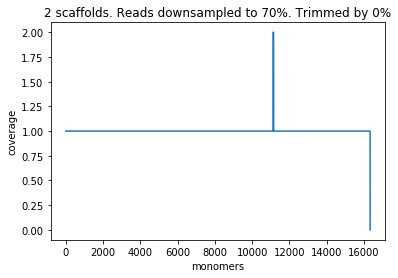

0 {'editDistance': 19, 'alphabetLength': 18, 'locations': [(43, 11088)], 'cigar': None}
1 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 16332)], 'cigar': None}
seed 910392 nreadsFreq 0.7 readCutFreq 0.05


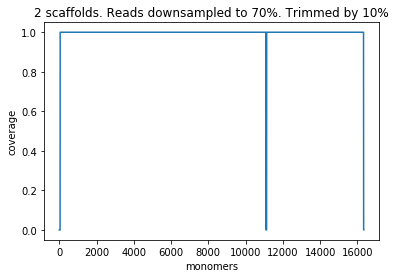

0 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1305, 7281)], 'cigar': None}
1 {'editDistance': 4, 'alphabetLength': 18, 'locations': [(6883, 11079)], 'cigar': None}
2 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13509, 16322)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(88, 1663)], 'cigar': None}
4 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 13866)], 'cigar': None}
seed 910392 nreadsFreq 0.7 readCutFreq 0.1


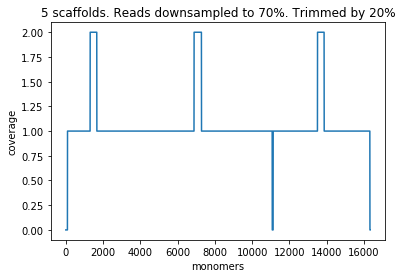

0 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(0, 1939)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1514, 8280)], 'cigar': None}
2 {'editDistance': 2, 'alphabetLength': 18, 'locations': [(5185, 10704)], 'cigar': None}
3 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(11128, 16337)], 'cigar': None}
seed 910392 nreadsFreq 0.5 readCutFreq 0


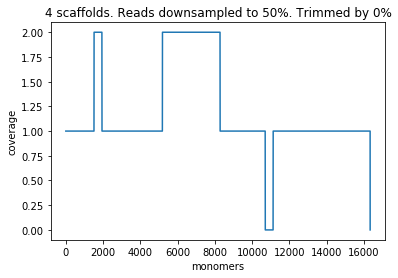

0 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(43, 1839)], 'cigar': None}
1 {'editDistance': 19, 'alphabetLength': 18, 'locations': [(1562, 8680)], 'cigar': None}
2 {'editDistance': 22, 'alphabetLength': 18, 'locations': [(5185, 10296)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 16332)], 'cigar': None}
seed 910392 nreadsFreq 0.5 readCutFreq 0.05


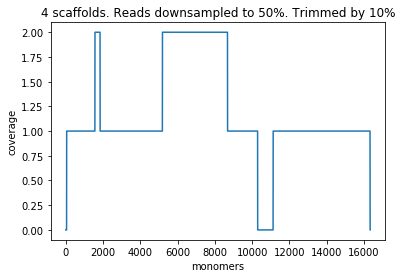

0 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13509, 16315)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(7125, 8574)], 'cigar': None}
2 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(88, 1787)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(1613, 3083)], 'cigar': None}
4 {'editDistance': 79, 'alphabetLength': 18, 'locations': [(2252, 7281)], 'cigar': None}
5 {'editDistance': 15, 'alphabetLength': 18, 'locations': [(11734, 13866)], 'cigar': None}
6 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8034, 10180)], 'cigar': None}
seed 910392 nreadsFreq 0.5 readCutFreq 0.1


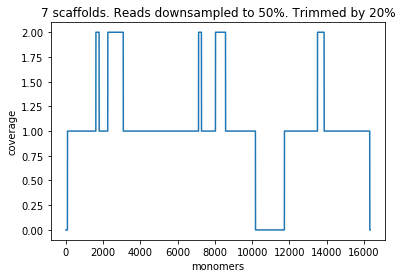

In [100]:
scaffolds_k400, dbs_k400 = subsample(monoreads, assembly, outdir='../data/subsampling')


In [77]:
# scaffolds_k400[(910392, 0.8, 0)]
# db = dbs_k400[(910392, 0.8, 0)]
all_long_monoreads = {r_id: monoread for r_id, monoread in monoreads.items()
                      if len(monoread) >= 100}
# mappings = db.map_reads(long_monoreads, verbose=False)

66.74874525645734 25.75045905251561
0 {'editDistance': 3, 'alphabetLength': 18, 'locations': [(0, 11154)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(11128, 16337)], 'cigar': None}
seed 910392 nreadsFreq 0.8 readCutFreq 0


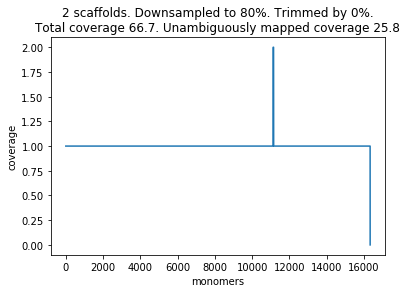

60.069653568368224 20.652956298200515
0 {'editDistance': 2, 'alphabetLength': 18, 'locations': [(43, 11088)], 'cigar': None}
1 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 16332)], 'cigar': None}
seed 910392 nreadsFreq 0.8 readCutFreq 0.05


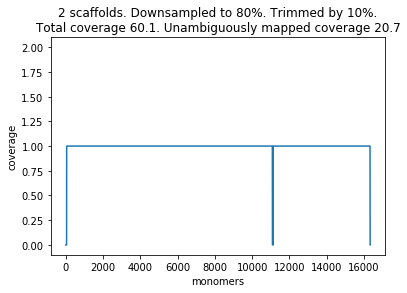

53.395152405435184 16.04651732158159
0 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1305, 7425)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(6916, 11088)], 'cigar': None}
2 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13505, 16323)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(88, 1663)], 'cigar': None}
4 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 13866)], 'cigar': None}
seed 910392 nreadsFreq 0.8 readCutFreq 0.1


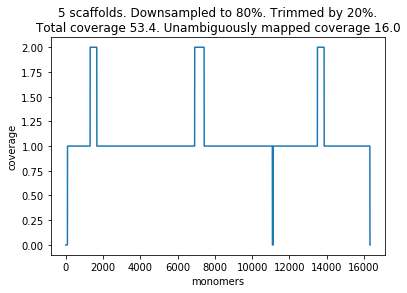

58.27126943322316 22.441302485004286
0 {'editDistance': 3, 'alphabetLength': 18, 'locations': [(0, 11154)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(11128, 16337)], 'cigar': None}
seed 910392 nreadsFreq 0.7 readCutFreq 0


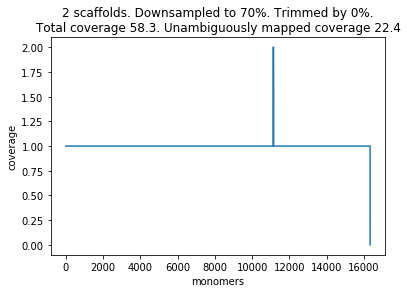

52.440629207981395 17.84257559064757
0 {'editDistance': 19, 'alphabetLength': 18, 'locations': [(43, 11088)], 'cigar': None}
1 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 16332)], 'cigar': None}
seed 910392 nreadsFreq 0.7 readCutFreq 0.05


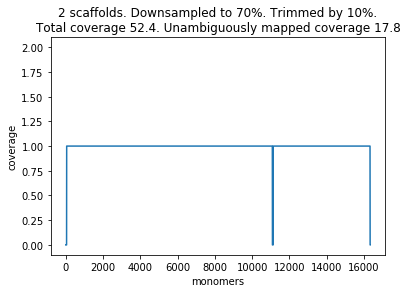

46.61494674990819 13.832721263312523
0 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1305, 7281)], 'cigar': None}
1 {'editDistance': 4, 'alphabetLength': 18, 'locations': [(6883, 11079)], 'cigar': None}
2 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13509, 16322)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(88, 1663)], 'cigar': None}
4 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 13866)], 'cigar': None}
seed 910392 nreadsFreq 0.7 readCutFreq 0.1


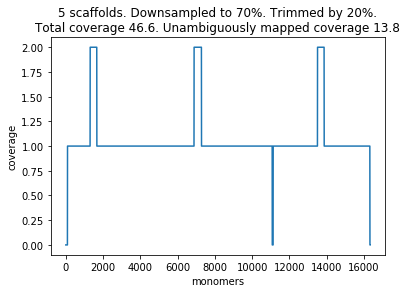

41.27512547435427 15.762639245929734
0 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(0, 1939)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(1514, 8280)], 'cigar': None}
2 {'editDistance': 2, 'alphabetLength': 18, 'locations': [(5185, 10704)], 'cigar': None}
3 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(11128, 16337)], 'cigar': None}
seed 910392 nreadsFreq 0.5 readCutFreq 0


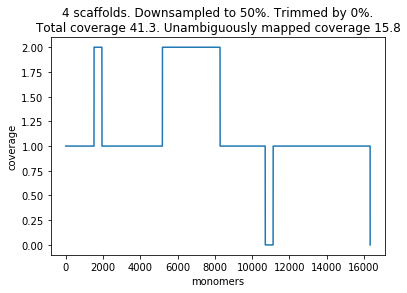

37.14438731790917 12.287672909780879
0 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(43, 1839)], 'cigar': None}
1 {'editDistance': 19, 'alphabetLength': 18, 'locations': [(1562, 8680)], 'cigar': None}
2 {'editDistance': 22, 'alphabetLength': 18, 'locations': [(5185, 10296)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(11128, 16332)], 'cigar': None}
seed 910392 nreadsFreq 0.5 readCutFreq 0.05


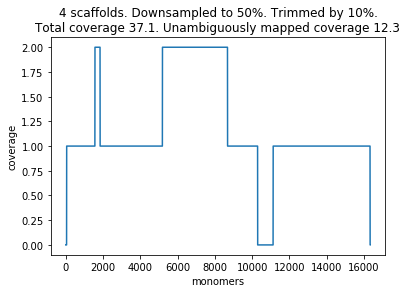

33.01836210062431 9.056677683927042
0 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(13509, 16315)], 'cigar': None}
1 {'editDistance': 1, 'alphabetLength': 18, 'locations': [(7125, 8574)], 'cigar': None}
2 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(88, 1787)], 'cigar': None}
3 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(1613, 3083)], 'cigar': None}
4 {'editDistance': 79, 'alphabetLength': 18, 'locations': [(2252, 7281)], 'cigar': None}
5 {'editDistance': 15, 'alphabetLength': 18, 'locations': [(11734, 13866)], 'cigar': None}
6 {'editDistance': 0, 'alphabetLength': 18, 'locations': [(8034, 10180)], 'cigar': None}
seed 910392 nreadsFreq 0.5 readCutFreq 0.1


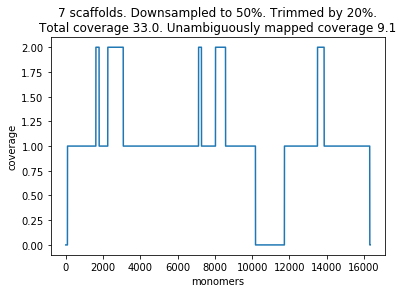

In [128]:
for (seed, nreads_freq, rc_freq), db in dbs_k400.items():
    random.seed(910392)
    long_monoreads_ids = random.sample(all_long_monoreads.keys(),
                                       k=int(len(all_long_monoreads)*nreads_freq))
    long_monoreads = {r_id: all_long_monoreads[r_id] for r_id in long_monoreads_ids}
    long_monoreads = deepcopy(long_monoreads)
    
    for read in long_monoreads.values():
        left_ind = int(len(read)*rc_freq)
        right_ind = int(len(read)*(1-rc_freq))
        read.trim_read(left_ind, right_ind)
    total_read_cov = sum(len(monoread) for monoread in long_monoreads.values()) / len(assembly)
    
    mappings = db.map_reads(long_monoreads, verbose=False)
    unambiguous_reads = {r_id: long_monoreads[r_id] for r_id in long_monoreads
                         if mappings[r_id] is not None and mappings[r_id][-2]}
    mapped_read_cov = sum(len(monoread) for monoread in unambiguous_reads.values()) / len(assembly)
    print(total_read_cov, mapped_read_cov)
    
    scaffolds, edge_scaffolds = scaffolding(db, mappings)
    cov = assembly_cov_scaffolds(assembly, scaffolds, verbose=True)
    mappings = db.map_reads(long_monoreads, verbose=False)
    plt.plot(cov)
    print('seed', seed, 'nreadsFreq', nreads_freq, 'readCutFreq', rc_freq)
    plt.title(f'{len(scaffolds)} scaffolds. Downsampled to {int(nreads_freq*100)}%. Trimmed by {int(rc_freq*100*2)}%.\nTotal coverage {total_read_cov:.1f}. Unambiguously mapped coverage {mapped_read_cov:.1f}')
    plt.xlabel('monomers')
    plt.ylabel('coverage')
    plt.ylim(-0.1, 2.1)
    plt.show()
                